# Statuses total time
Sums the times instances spend in one of each states in the diagram saved as
"statuses.drawio". Unknown times are summed as "unknown"

In [1]:
import json
import sys
import pandas
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# QUEUE = set(["0-2", "1-2", "assumptions:", "1-1", "1-0"])
# RESUB = set(["4-1", "4-0", "5-1", "6-1", "7-1", "8-1", "assumptions:", "5-0", "6-0", "7-0", \
#   "8-0"])
# READY = set(["0-3", "2-3", "0-9", "2-9", "9-3", "2-7", "2-8", "9-7", "9-8", \
#   "9-9", "0-7", "0-8", "assumptions:", "2-0", "2-4", "9-4", "9-1"])
# RUN = set(["3-1", "3-10", "3-4", "3-5", "3-6", "3-7", "3-8", "10-5", "10-6", \
#   "10-7", "10-8", "10-4", "10-10", "10-1", "assumptions:", "3-0", "10-0", "3-3"])

QUEUE = set(["0-2", "1-2"])
ENDED = set(["5-1", "6-1", "7-1", "8-1"])
READY = set(["0-3", "0-9", "2-3", "2-9", "9-3", "9-9"])
RUN = set(["3-1", "3-4", "3-5", "3-6", "3-7", "3-8", "3-10", "10-1", "10-4", "10-5", "10-6", "10-7", "10-8", "10-10"])
EVICT = set(["4-1", "4-0"])

In [3]:
DIR = "/Users/maggicl/git/bachelorThesis"

In [40]:
def to_name(et):
    if et == 4: 
        return 'EVICT'
    elif et == 5: 
        return 'FAIL'
    elif et == 6:
        return 'FINISH'
    elif et == 7:
        return 'KILL'
    elif et == 8:
        return 'LOST'
    else:
        return 'NO_TERM'

def create_df(cluster):
    obj = {}

    filename = DIR + "/machine_time_waste/" + cluster + "_state_changes.json"

    with open(filename, 'r') as f:
        obj = json.loads(f.read())
    
    data = {'Last termination': [], 'time_type': [], 'time_ms': []}
    totals = {}
    
    def add_record(et, tt, time):
        data['Last termination'].append(to_name(et))
        data['time_type'].append(tt)
        data['time_ms'].append(time / 1000)

    for pair in obj["data"]:
        qt = et = rt = xt = vt = ut = 0

        pair[0] = 0 if pair[0] is None else pair[0]

        x = pair[1]
        for k in x.keys():
            if k in QUEUE:
                qt += x[k]
            elif k in ENDED:
                et += x[k]
            elif k in READY:
                rt += x[k]
            elif k in RUN:
                xt += x[k]
            elif k in EVICT:
                vt += x[k]
            else:
                ut += x[k]

        add_record(pair[0], 'queued', qt)
        add_record(pair[0], 'ended', et)
        add_record(pair[0], 'ready', rt)
        add_record(pair[0], 'running', xt)
        add_record(pair[0], 'evicted', vt)
        add_record(pair[0], 'unknown', ut)
        totals[pair[0]] = (qt + et + rt + xt + vt + ut) / 1000
        
    return (pandas.DataFrame(data, columns=['Last termination', 'time_type', 'time_ms']), totals)

## Graph 1: Absolute total time spent per status per "last termination" type

In [45]:
def graph_1(df, cluster):
    #sns.set_theme(style="ticks")
    g = sns.histplot(df, x="Last termination", weights="time_ms", shrink=.5,
                 hue="time_type", multiple="dodge", discrete=True, legend=False)
    g.set_yscale("log")
    g.set_ylabel("Total (milliseconds)") 
    g.set_title("Cluster " + cluster + ": Absolute total time spent per status per \"last termination\" type")
    #g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Graph 2: Relative total time spent per status per "last termination" type

Values are proportions on total for each "last termination" type

In [46]:
def graph_2(df, cluster, totals):
    df = df.copy()
    for i in [0,4,5,6,7,8]:
        df.loc[df["Last termination"] == to_name(i), "time_ms"] = df["time_ms"][df["Last termination"] == to_name(i)] / totals[i]

    h = sns.histplot(df, x="Last termination", 
                     weights="time_ms", shrink=.5, common_bins=True,
                     hue="time_type", multiple="stack", discrete=True, legend=False)
    #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    h.set_title("Cluster " + cluster + ": Relative total time spent per status per \"last termination\" type") 

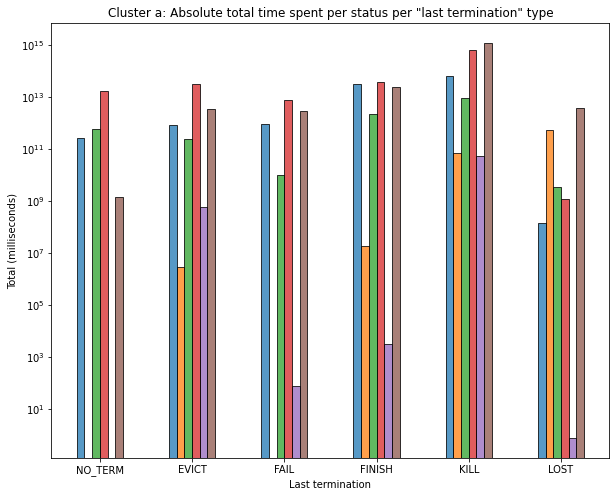

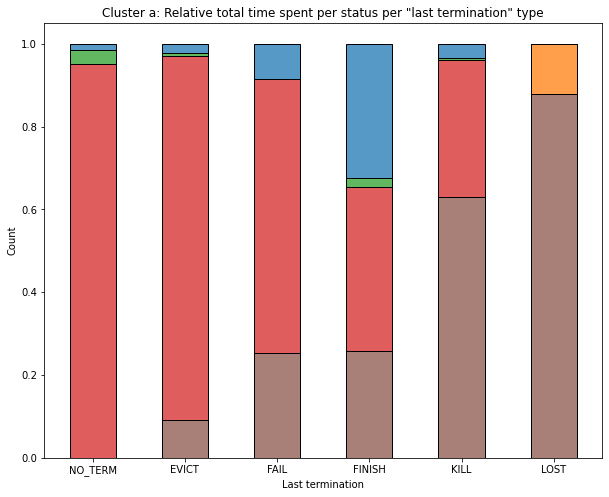

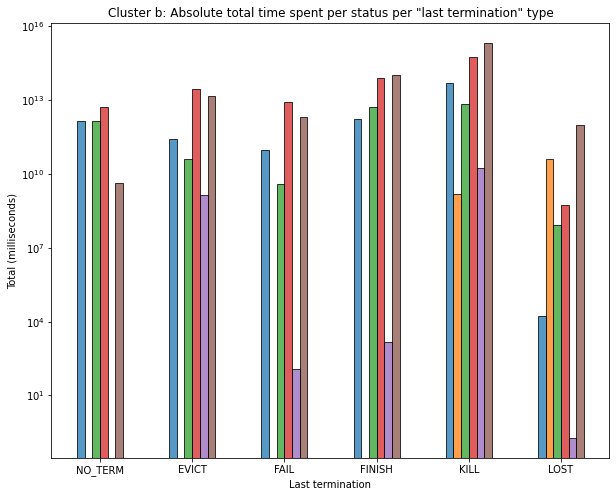

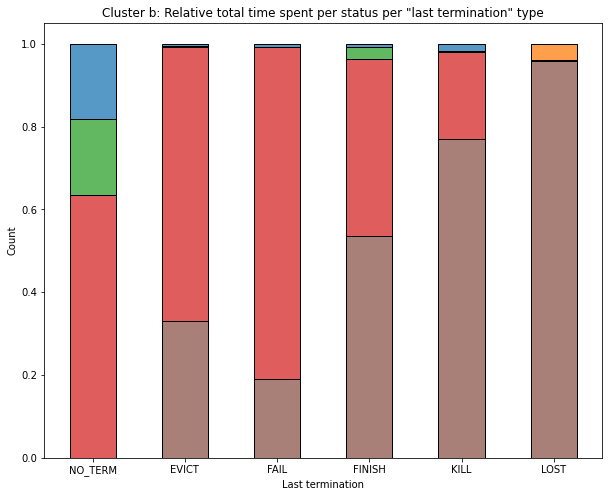

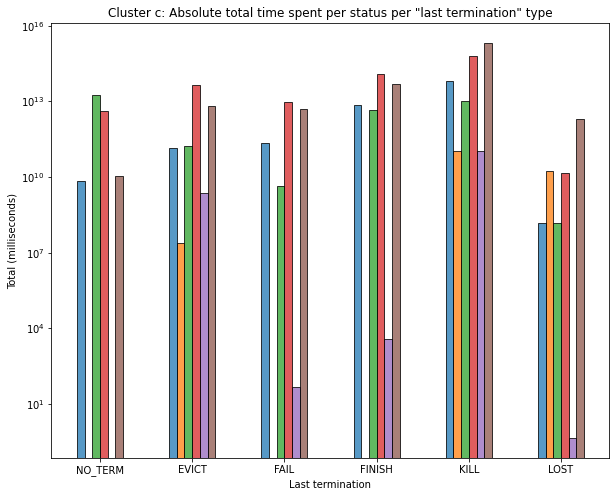

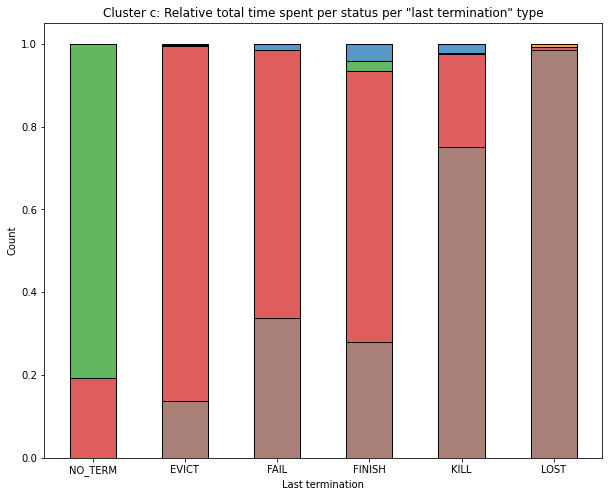

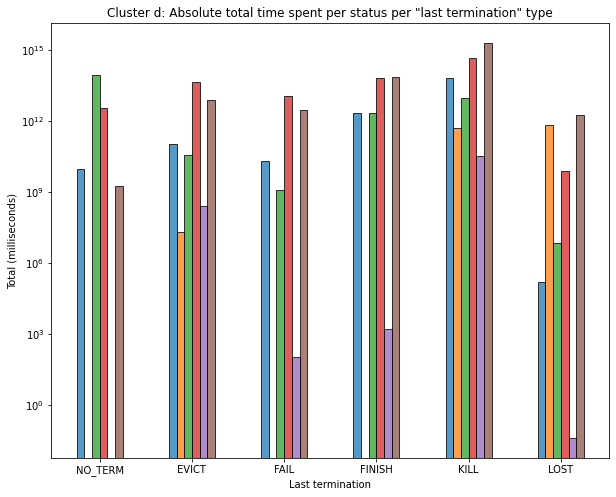

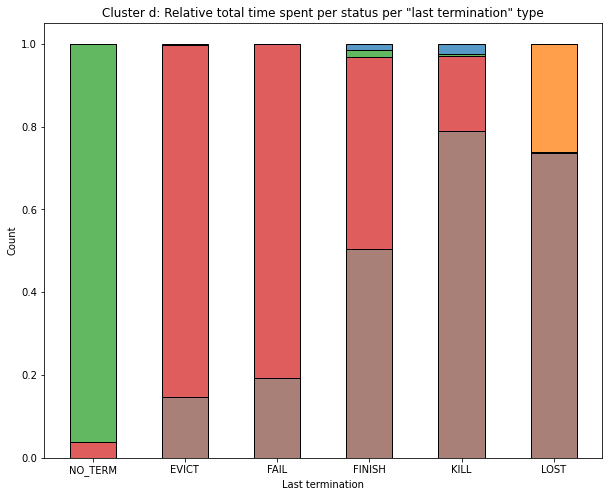

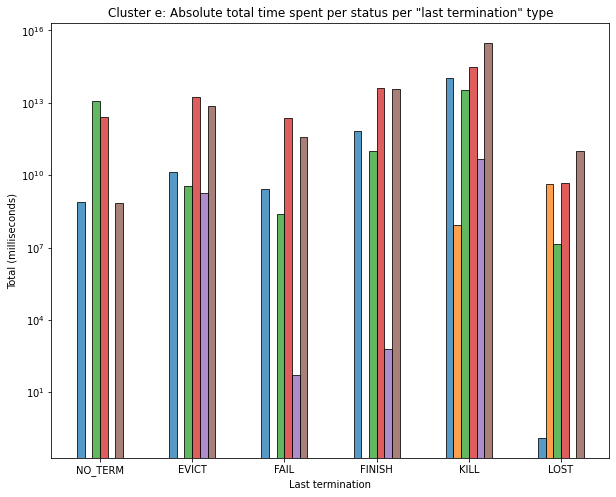

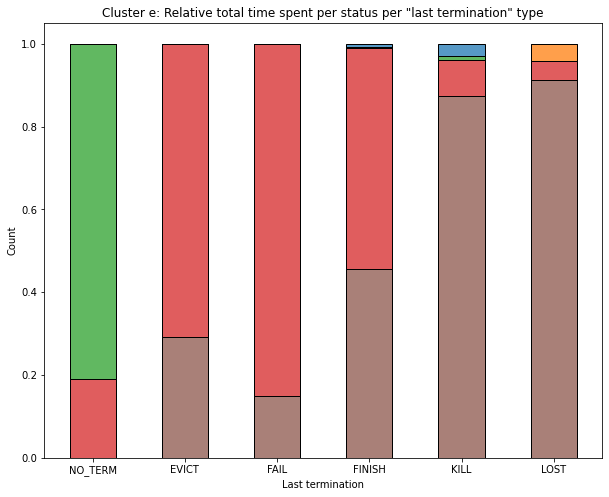

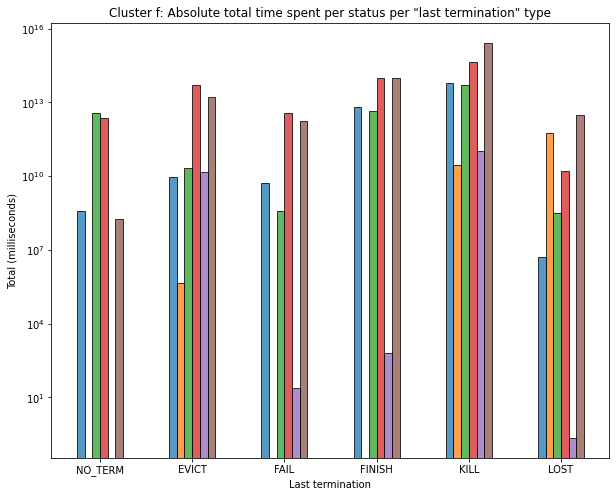

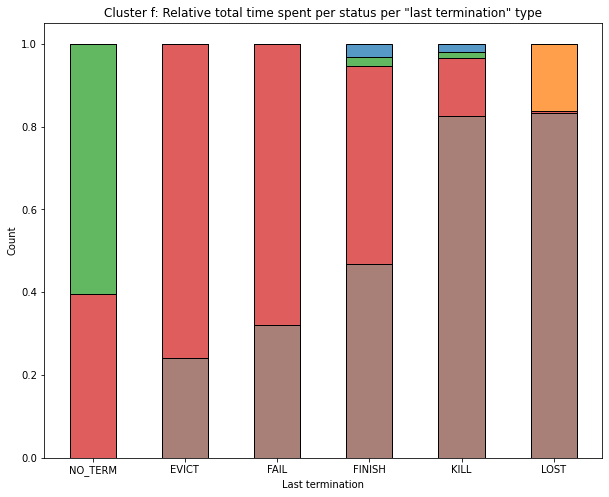

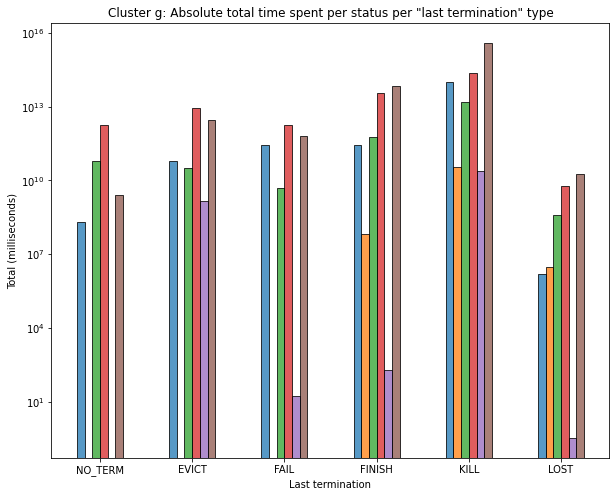

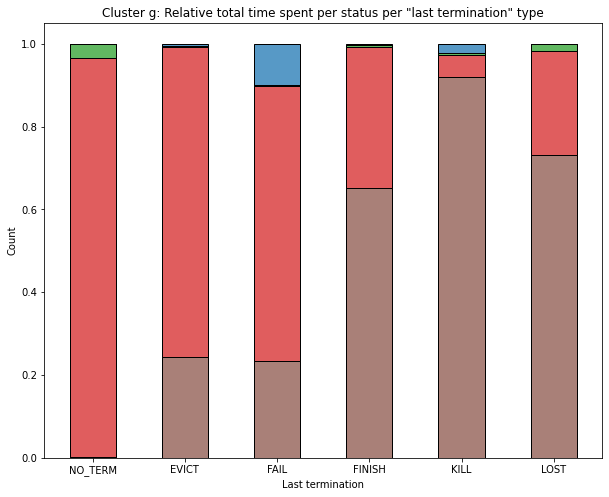

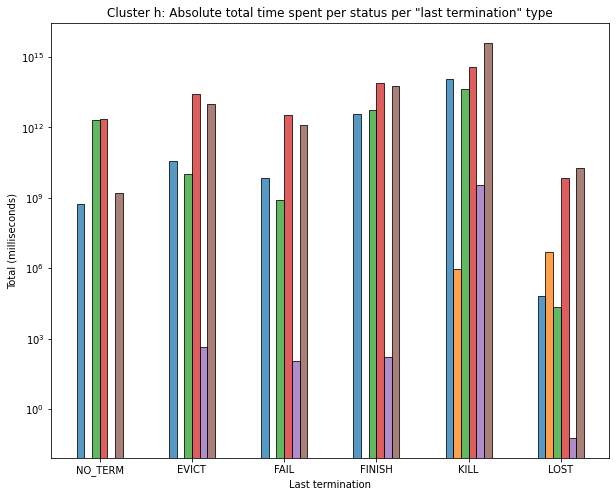

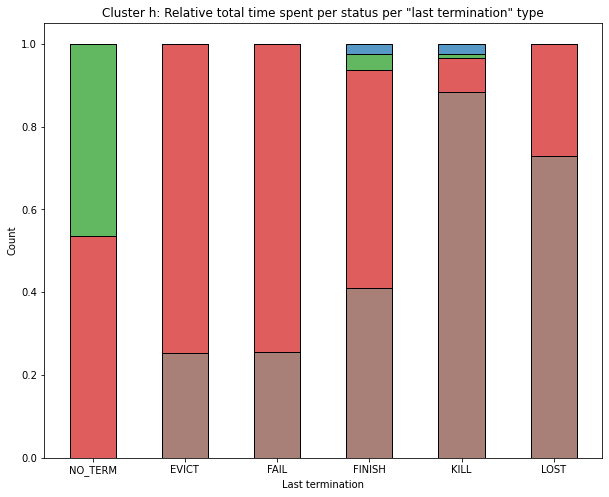

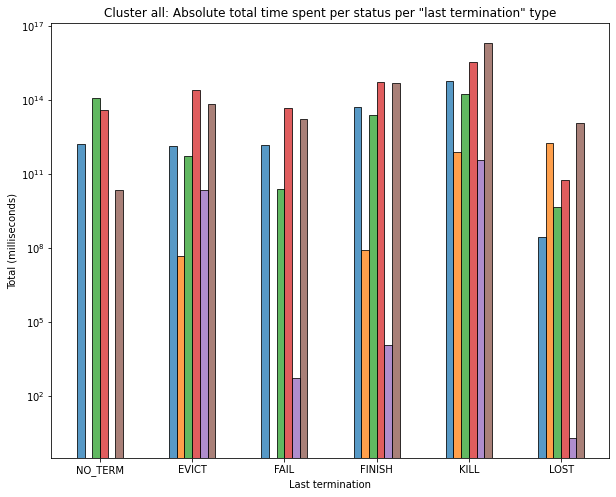

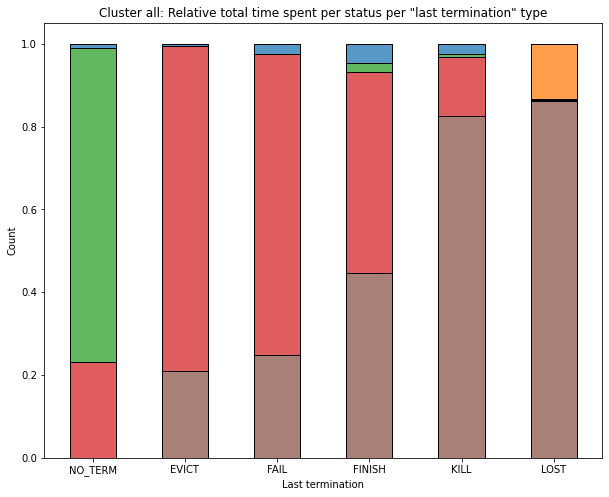

In [47]:
dft = None
tts = None

for cluster in "abcdefgh":
    df, totals = create_df(cluster)

    plt.figure(figsize=(10,8))
    graph_1(df, cluster)
    plt.figure(figsize=(10,8))
    graph_2(df, cluster, totals)
    
    if dft is None:
        dft = df
        tts = totals
    else:
        dft.loc[:, "time_ms"] = dft["time_ms"].add(df["time_ms"], fill_value=0)
        for key in totals:
            tts[key] += totals[key]

plt.figure(figsize=(10,8))
graph_1(dft, "all")
plt.figure(figsize=(10,8))
graph_2(dft, "all", tts)

In [48]:
dft

Last termination time_type       time_ms
0           NO_TERM    queued  1.699297e+12
1           NO_TERM     ended  0.000000e+00
2           NO_TERM     ready  1.252067e+14
3           NO_TERM   running  3.842227e+13
4           NO_TERM   evicted  0.000000e+00
5           NO_TERM   unknown  2.341963e+10
6             EVICT    queued  1.435821e+12
7             EVICT     ended  4.767580e+07
8             EVICT     ready  5.606274e+11
9             EVICT   running  2.504113e+14
10            EVICT   evicted  2.282988e+10
11            EVICT   unknown  6.726776e+13
12             FAIL    queued  1.578510e+12
13             FAIL     ended  0.000000e+00
14             FAIL     ready  2.613915e+10
15             FAIL   running  4.833851e+13
16             FAIL   evicted  5.572550e+02
17             FAIL   unknown  1.659997e+13
18           FINISH    queued  5.357666e+13
19           FINISH     ended  8.581627e+07
20           FINISH     ready  2.440088e+13
21           FINISH   running  5.511501e+14
22           FINISH   evicted  1.150760e+04
23           FINISH   unknown  5.054797e+14
24             KILL    queued  6.169786e+14
25             KILL     ended  7.602624e+11
26             KILL     ready  1.803627e+14
27             KILL   running  3.653008e+15
28             KILL   evicted  3.912275e+11
29             KILL   unknown  2.110184e+16
30             LOST    queued  2.866478e+08
31             LOST     ended  1.830379e+12
32             LOST     ready  4.515414e+09
33             LOST   running  5.671707e+10
34             LOST   evicted  2.014000e+00
35             LOST   unknown  1.173356e+13